In [1]:
%run System_Definition.ipynb

# Summary

Credit to Julio, minor modifications by Cory.

This document is to provide a calculation process for determining the required power necessary to power the Electric Feed System.

In this document, variables for Pressure, Mass Flowrate, Fluid Properties, and Plumbing Geometry will be self-defined variables.

Equations will use the defined variables for calculations.

I found [this website](https://www.pumpschool.com/applications/NPSH.pdf) useful, as well as [this](https://en.wikipedia.org/wiki/Hydraulic_head).

# Parameter Definitions

In [2]:
RtoD = EPSILON_PIPE / D_PIPE # Rougness to Diameter Ratio
# used to determine friction factors?

# Internal Pipe Flow Calculations

In [3]:
def pipe_flow(mdot, material):
    qdot = mdot / material['rho'] # m^3/s Volumetric Flowrate
    v    = qdot / A_PIPE # m/s Fluid Velocity
    v_lfets = qdot / LFETS_PIPE_AREA
    Re   = material['rho'] * v * D_PIPE / material['mu'] # Reynolds Number
    return qdot, v, v_lfets, Re

Up to this point, the goal of the file has been to identify the characteristics of the system along with calculated some critical factors such as:
* The Reynolds nubmer which helps predict flow characteristics of moving fluids
* The fluid velocity which will helps us predict loss factors for the system. 

# Plumbing Losses
System Major Losses
(energy loss due to viscous effects (friction) through straight pipe sections).
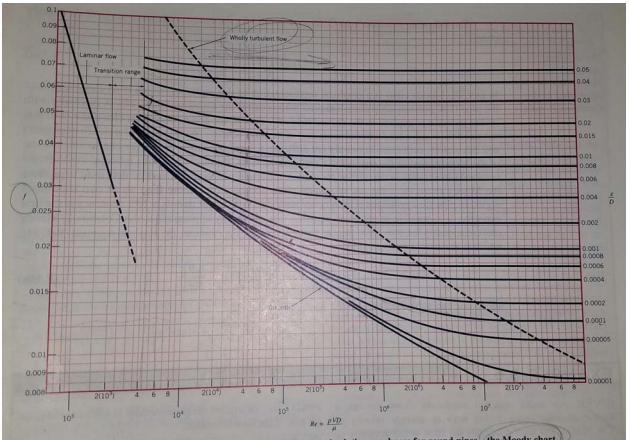

System Minor Losses (energy losses due to changes in flow direction caused by plumbing connections.)
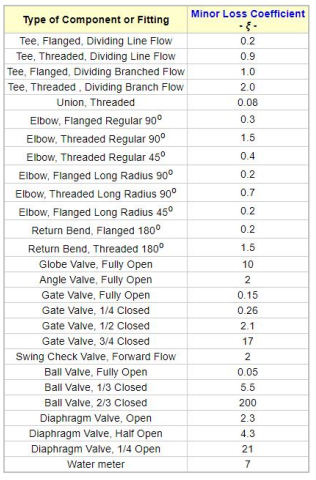

In [5]:
def head_loss(fric, plum_len, v):
    h_LMajor = fric * plum_len * v**2 / (D_PIPE * 2 * G_N) # m Head Major Loss
    h_LMinor = K_L * v**2 / (2 * G_N) # m Head Minor Loss
    return h_LMajor + h_LMinor

## Reference Equations for Mechanical Energy Process
Mechanical Energy Equation (Energy per Unit Weight, Nm / N = m):
$$\frac{P_{out}}{\gamma} + \frac{v_{out}^2}{2g} + z_{out} = \frac{P_{in}}{\gamma} + \frac{v_{in}^2}{2g} + z_{in} + h_s - h_{L,total}$$

Pump Assumptions:

$v_{out} = v_{in}$: Constant mass flow through constant diameter pipe makes for constant velocity. $v_{in}$ is the velcity before the pump, $v_{out}$ is the fluid leaving the pump.

$z_{out} = z_{in}$: Elevation difference between Propellant tank and rocket engine producing negligible amount of system energy.

Reduced Mechanical Energy Equation:
$$\frac{P_{out}}{\gamma}  = \frac{P_{in}}{\gamma} + h_s - h_{L,total}$$

Solve for Shaft Work:
$$h_s = \frac{P_{out}}{\gamma} - \frac{P_{in}}{\gamma} + h_{L,total}$$

$$h_s = \frac{W_{shaft, net, in}}{g}$$ (work per unit weight, unit of length)

This section, the calculated power requirement can be used to estimate the battery requirement for a propellant system. Reassign any necessary variable once new design and experimental losses are identified.

If the propellant tank size is known, this value can be used directly instead of determined with mass flow, gravity, and estimated operation time as shown above. 

In [6]:
def power_req(p_ch, mdot, material, p_in, fric, plum_len, delP_inj, static_head):
    qdot, v, v_lfets, Re = pipe_flow(mdot, material)
    h_L         = head_loss(fric, plum_len, v) # Total Head Loss
    p_out       = 1.25 * (p_ch + delP_inj) # Required Outlet Pressure including injector and venturi losses 
    delP        = p_out - p_in
    spec_dens   = G_N * material['rho']
    h_s         = delP / material['rho'] + h_L * G_N # Shaft Work Head times standard gravity
    if h_s <= 0:
        return v_lfets, p_out, 0, 0
    W           = mdot * h_s / PUMP_EFF # power requirement
    tau         = 2 # no less than 2, to avoid cavitation
    inlet_head  = p_in / spec_dens
    vap_p_head  = material['p_v'] / spec_dens
    npsh_a      = inlet_head + static_head - vap_p_head - h_L # available net pressure suction head
    npsh_r      = max(0, npsh_a / tau) # rotational. pardon the kludge...
    rpm         = U_SS * (npsh_r*3.281)**0.75 / (21.2 * np.sqrt(qdot*35.31)) # magic numbers are unit conversion weirdness
    #print(material['name'], ' SH: ',static_head, ' HL: ', h_L)
    return v_lfets, p_out, W * 1.111, rpm * 1.111 # FOS so that operating conditions are 80% of maximum